In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../final_table.csv")

In [4]:
df

,property_type,wall_type,age,issue_type,orientation,ventilation,window_type,occupancy,drying_clothes,main_issue_location,...,cause,analysis,heating_system,property_type_categorised,ventilation_categorised,window_type_categorised,cause_primary,cause_secondary,analysis_primary,analysis_secondary
0,two bedroom ground floor flat,cavity,not mentioned,both,not mentioned,extraction unit in the bathroom,not mentioned,not mentioned,yes,children's bedroom,...,The reported damp and mould issues are primari...,The main causes of the reported damp and mould...,Not mentioned,ground floor flat,extract ventilation,not mentioned,poor ventilation,external moisture penetration,poor ventilation,other/unclear
1,terraced four bedroom dwelling,solid,not mentioned,both,not mentioned,"mechanical extraction unit in kitchen, trickle...",not mentioned,not mentioned,not mentioned,dining room,...,The reported damp and mould issues are primari...,The reported damp and mould issues are primari...,Gas central heating,mid terrace,extract ventilation,not mentioned,external moisture penetration,rising damp,poor ventilation,rising damp
2,ground floor apartment in a purpose built block,solid,not mentioned,both,not mentioned,not mentioned,not mentioned,not mentioned,not mentioned,"bathroom, kitchen",...,The main causes of the reported damp and mould...,The reported damp and mould issues in the apar...,Not mentioned,flat,not mentioned,not mentioned,internal leaks/plumbing,external moisture penetration,poor ventilation,none
3,two bedroom ground floor flat,cavity,not mentioned,mould,not mentioned,"mechanical extraction unit in the bathroom, PI...",not mentioned,1 adult and 2 children,not mentioned,bathroom cupboard,...,The mould issues are primarily caused by a com...,The main causes of the reported damp and mould...,Not mentioned,ground floor flat,continuous mechanical ventilation,not mentioned,poor ventilation,internal leaks/plumbing,poor ventilation,insufficient heating
4,mid-block ground floor flat,cavity,pre-1960,damp,not mentioned,"extractor in bathroom, trickle vents on windows",uPVC,not mentioned,yes,"bathroom, kitchen",...,The main causes of the reported issues include...,The reported high moisture levels in the bathr...,Not mentioned,ground floor flat,extract ventilation,uPVC,poor ventilation,none,poor ventilation,other/unclear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ground floor flat in a purpose-built block,cavity,pre-dating 1965,mould,north,uPVC windows with trickle vents,uPVC,not mentioned,not mentioned,two bedrooms,...,The mould issues in the property are primarily...,The main causes of the reported mould issues i...,Not mentioned,ground floor flat,extract ventilation,uPVC,poor ventilation,rising damp,poor ventilation,residual construction moisture
996,three-bedroomed house,cavity,not mentioned,both,not mentioned,passive trickle vents and mechanical extractio...,not mentioned,not mentioned,yes,bedroom 1 and bathroom,...,The reported issues are primarily caused by a ...,The reported issues of damp and mould in the p...,Gas central heating,detached,extract ventilation,not mentioned,poor ventilation,internal leaks/plumbing,poor ventilation,occupant behaviour
997,first floor apartment in a modern purpose buil...,cavity,not mentioned,both,not mentioned,not mentioned,not mentioned,not mentioned,not mentioned,lounge,...,The main causes of the reported damp and mould...,The reported damp and mould issues are primari...,Gas central heating,flat,not mentioned,not mentioned,external moisture penetration,poor ventilation,external moisture penetration,poor ventilation
998,first floor flat in a purpose-built block,cavity,not mentioned,mould,not mentioned,centralized MEV system and passive ventilation...,uPVC,not mentioned,yes,"master bedroom, kitchen",...,The main causes of the reported damp and mould...,The main causes of the reported damp and mould...,Gas central heating,flat,continuous mechanical ventilation,uPVC

In [5]:
df.heating_system.value_counts()

heating_system
Gas central heating                                           529
Not mentioned                                                 460
Electric storage heaters or radiators                           8
Oil or LPG central heating                                      2
Gas central heating; Electric storage heaters or radiators      1
Name: count, dtype: int64

In [6]:
ventilation = df[
    (df["cause_primary"] == "poor ventilation") |
    (df["cause_secondary"] == "poor ventilation")
]
non_ventilation = df[
    (df["cause_primary"] != "poor ventilation") &
    (df["cause_secondary"] != "poor ventilation")
]


In [7]:
df["ventilation_issue"] = df["cause_primary"].str.lower().eq("poor ventilation")


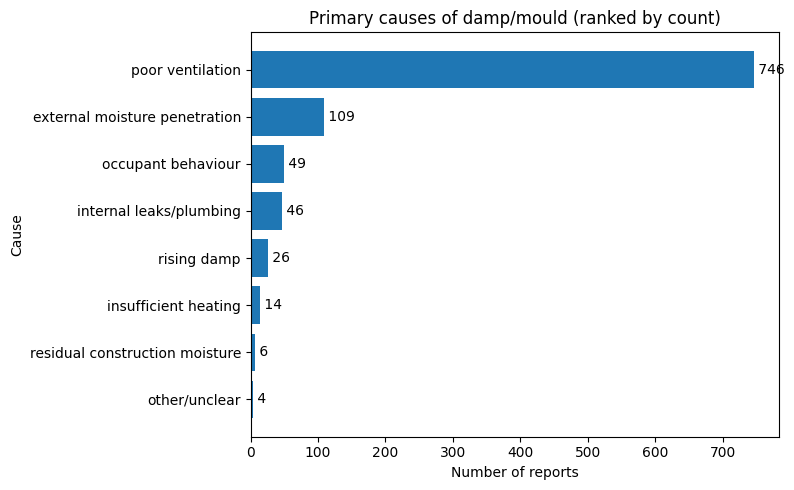

In [8]:


# Pick the column to rank
col = "cause_primary"

# Counts (sorted)
counts = df[col].value_counts().sort_values(ascending=True)

# Plot: ranked horizontal bar chart (counts)
plt.figure(figsize=(8, 5))
plt.barh(counts.index, counts.values)
plt.title("Primary causes of damp/mould (ranked by count)")
plt.xlabel("Number of reports")
plt.ylabel("Cause")
for i, v in enumerate(counts.values):
    plt.text(v, i, f" {v}", va="center")  # annotate counts
plt.tight_layout()
plt.show()


In [9]:
# Number of reports where each cause is mentioned as either primary or secondary cause:
import pandas as pd

# Count for primary causes
primary_counts = df['cause_primary'].value_counts().rename("primary")

# Count for secondary causes
secondary_counts = df['cause_secondary'].value_counts().rename("secondary")

# Combine into one table
cause_table = pd.concat([primary_counts, secondary_counts], axis=1).fillna(0)

# Add total column
cause_table["total"] = cause_table["primary"] + cause_table["secondary"]

# Make sure counts are integers
cause_table = cause_table.astype(int)

display(cause_table)

,primary,secondary,total
poor ventilation,746,130,876
external moisture penetration,109,140,249
occupant behaviour,49,203,252
internal leaks/plumbing,46,94,140
rising damp,26,64,90
insufficient heating,14,28,42
residual construction moisture,6,21,27
other/unclear,4,17,21
none,0,303,303


In [12]:
# Crosstab ventilation system vs whether ventilation is the issue
ct = pd.crosstab(df["ventilation_categorised"], df["ventilation_issue"])

display(ct)

ct_pct = ct.div(ct.sum(axis=1), axis=0).round(2) * 100
display(ct_pct)


ventilation_issue,False,True
ventilation_categorised,,
MVHR,2,11
PIV,1,10
continuous mechanical ventilation,12,63
extract ventilation,130,539
natural ventilation,31,82
none,2,2
not mentioned,69,28
other,3,6
poor ventilation,4,5


ventilation_issue,False,True
ventilation_categorised,,
MVHR,15.0,85.0
PIV,9.0,91.0
continuous mechanical ventilation,16.0,84.0
extract ventilation,19.0,81.0
natural ventilation,27.0,73.0
none,50.0,50.0
not mentioned,71.0,29.0
other,33.0,67.0
poor ventilation,44.0,56.0


Takeaways:

Extract ventilation is by far the most common, but also seems to be ineffective or not used properly - seems less effective than natural ventilation even from this small sample size

When ventilation system is not mentioned, its largely because the surveyor deems the issue to be non-ventilation related, but sometimes the information is missing even when they think its a ventilation issue


# main locations

In [13]:
import re
LOCATION_KEYWORDS = {
    "Bathroom": [r"bathroom"],
    "Bedroom": [r"bedroom"],
    "Kitchen": [r"kitchen"],
    "Living/Lounge": [r"living", r"lounge"],
}

def categorize_location(text):
    # Handle missing or NaN
    if not isinstance(text, str) or text.strip() == "" or text.strip().lower() == "not mentioned":
        return "Not mentioned"

    text = text.lower()
    for category, patterns in LOCATION_KEYWORDS.items():
        for pat in patterns:
            if re.search(pat, text):
                return category
    return "Other"


# Apply categorisation (first match only)
df["main_issue_location_categorised"] = df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

display(counts)

,Location,Count,Percent
0,Bedroom,389,38.9
1,Bathroom,249,24.9
2,Other,130,13.0
3,Living/Lounge,116,11.6
4,Kitchen,87,8.7
5,Not mentioned,29,2.9


In [14]:
extract_df = df[df["ventilation_categorised"]=="extract ventilation"].copy()
natural_df = df[df["ventilation_categorised"]=="natural ventilation"].copy()
PIV_df = df[df["ventilation_categorised"]=="PIV"].copy()
nm_df = df[df["ventilation_categorised"]=="not mentioned"].copy()


In [15]:
# Apply categorisation (first match only)
extract_df["main_issue_location_categorised"] = extract_df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = extract_df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

print("extract ventilation:")
display(counts)



# Apply categorisation (first match only)
natural_df["main_issue_location_categorised"] = natural_df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = natural_df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

print("\nnatural ventilation:")
display(counts)



# Apply categorisation (first match only)
PIV_df["main_issue_location_categorised"] = PIV_df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = PIV_df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

print("  \nPIV:")
display(counts)



# Apply categorisation (first match only)
nm_df["main_issue_location_categorised"] = nm_df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = nm_df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

print("  \nnot mentioned:")
display(counts)


extract ventilation:


,Location,Count,Percent
0,Bedroom,275,41.1
1,Bathroom,190,28.4
2,Living/Lounge,72,10.8
3,Other,62,9.3
4,Kitchen,54,8.1
5,Not mentioned,16,2.4



natural ventilation:


,Location,Count,Percent
0,Bedroom,48,42.5
1,Living/Lounge,22,19.5
2,Bathroom,18,15.9
3,Kitchen,13,11.5
4,Other,11,9.7
5,Not mentioned,1,0.9


  
PIV:


,Location,Count,Percent
0,Bedroom,6,54.5
1,Bathroom,3,27.3
2,Not mentioned,1,9.1
3,Other,1,9.1


  
not mentioned:


,Location,Count,Percent
0,Other,36,37.1
1,Bedroom,21,21.6
2,Kitchen,13,13.4
3,Living/Lounge,13,13.4
4,Bathroom,9,9.3
5,Not mentioned,5,5.2


In [16]:
# Crosstab of room vs primary cause
ct = pd.crosstab(df["main_issue_location_categorised"], df["cause_primary"])

# Add row percentages (optional)
ct_pct = ct.div(ct.sum(axis=1), axis=0).round(2) * 100

display(ct)
display(ct_pct)

cause_primary,external moisture penetration,insufficient heating,internal leaks/plumbing,occupant behaviour,other/unclear,poor ventilation,residual construction moisture,rising damp
main_issue_location_categorised,,,,,,,,
Bathroom,12,3,19,11,0,197,1,6
Bedroom,30,10,6,26,1,310,1,5
Kitchen,15,1,9,2,0,56,1,3
Living/Lounge,21,0,3,5,2,81,0,4
Not mentioned,0,0,3,1,0,21,1,3
Other,31,0,6,4,1,81,2,5


cause_primary,external moisture penetration,insufficient heating,internal leaks/plumbing,occupant behaviour,other/unclear,poor ventilation,residual construction moisture,rising damp
main_issue_location_categorised,,,,,,,,
Bathroom,5.0,1.0,8.0,4.0,0.0,79.0,0.0,2.0
Bedroom,8.0,3.0,2.0,7.0,0.0,80.0,0.0,1.0
Kitchen,17.0,1.0,10.0,2.0,0.0,64.0,1.0,3.0
Living/Lounge,18.0,0.0,3.0,4.0,2.0,70.0,0.0,3.0
Not mentioned,0.0,0.0,10.0,3.0,0.0,72.0,3.0,10.0
Other,24.0,0.0,5.0,3.0,1.0,62.0,2.0,4.0


Takeaways:

Bedrooms and bathrooms seem to suffer from poor ventilation the most

In [62]:



ct = pd.crosstab(df["wall_type"], df["cause_primary"])
ct_pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(1)

display(ct)
display(ct_pct)


cause_primary,external moisture penetration,insufficient heating,internal leaks/plumbing,lifestyle factors,other/unclear,poor ventilation,residual construction moisture,rising damp
wall_type,,,,,,,,
cavity,34,5,15,10,7,143,2,7
not mentioned,4,0,1,0,0,11,0,0
solid,21,0,9,3,0,38,1,6
timber,0,0,1,0,1,3,0,1


cause_primary,external moisture penetration,insufficient heating,internal leaks/plumbing,lifestyle factors,other/unclear,poor ventilation,residual construction moisture,rising damp
wall_type,,,,,,,,
cavity,15.2,2.2,6.7,4.5,3.1,64.1,0.9,3.1
not mentioned,25.0,0.0,6.2,0.0,0.0,68.8,0.0,0.0
solid,26.9,0.0,11.5,3.8,0.0,48.7,1.3,7.7
timber,0.0,0.0,16.7,0.0,16.7,50.0,0.0,16.7


Takeaways:
cavity seems to be 